In [78]:
import numpy as np
np.random.seed(123)
n_samples = 10000
n_features = 200
n_outputs = 1
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, 2))
y = (X[:, :n_outputs]**2 + 1) * T[:, [0]] + T[:, [1]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [79]:
from econml.tree import Tree
from econml.grf import LinearMomentGRFCriterion
from econml.tree import BestSplitter
from econml.tree import DepthFirstTreeBuilder
from sklearn.model_selection import train_test_split
import numpy as np


def fit(X, y, n_features, n_outputs, random_state, subsample_fr=.7, replace=False, honest=True):
    max_depth = 100
    min_samples_split = 2
    min_samples_leaf = 20
    min_weight_leaf = 0
    min_impurity_decrease = 0
    min_balancedness_tol = .3
    max_features = n_features
    n_outputs = n_outputs
    n_samples = X.shape[0]

    random_state = np.random.RandomState(random_state)
    inds = random_state.choice(X.shape[0], int(np.ceil(subsample_fr * X.shape[0])), replace=replace)
    sample_weight = np.zeros(X.shape[0])
    sample_weight[inds] = 1

    if honest:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = train_test_split(X, y, sample_weight,
                                                                                            np.arange(X.shape[0]),
                                                                                            train_size=.5,
                                                                                            random_state=random_state)
    else:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = X, X, y, y, sample_weight, sample_weight,\
            np.arange(X.shape[0]), np.arange(X.shape[0])
    tree = Tree(n_features, n_outputs, store_jac=True)
    criterion = LinearMomentGRFCriterion(n_outputs, n_features, Xtrain.shape[0], Xval.shape[0])
    splitter = BestSplitter(criterion, max_features, min_samples_leaf, min_weight_leaf,
                            min_balancedness_tol, random_state)
    builder = DepthFirstTreeBuilder(splitter, min_samples_split, min_samples_leaf, min_weight_leaf,
                                    max_depth, min_impurity_decrease)
    builder.build(tree, Xtrain, ytrain, Xval, yval, n_features,
                  sample_weight=sample_weight_train, sample_weight_val=sample_weight_val, store_jac=True)
    if honest:
        sample_weight[inds_train] = 0
    return tree, sample_weight

In [80]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=20, n_jobs=-1, verbose=1).fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.1s finished


In [81]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

n_features = X.shape[1]
n_outputs = T.shape[1]
alpha = y * T
pointJ = cross_product(T, T)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(123)
forest = Parallel(n_jobs=-1, backend='loky', verbose=1)(
                    delayed(fit)(Data[:Data.shape[0]//2], y[:Data.shape[0]//2], n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                         subsample_fr=.9, replace=False, honest=False) for _ in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


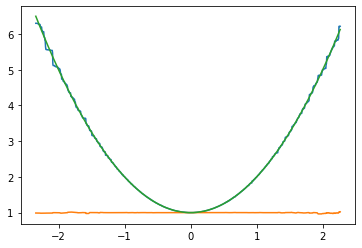

In [82]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest), axis=0))
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


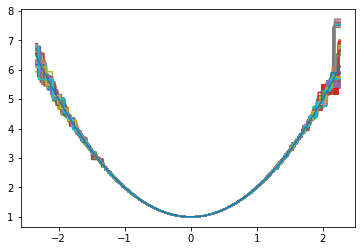

In [83]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest))[:, :, 0].T)
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()

In [84]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

n_features = X.shape[1]
n_outputs = T.shape[1]
alpha = y * T
pointJ = cross_product(T, T)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(123)
forest = Parallel(n_jobs=-1, backend='loky', verbose=1)(
                    delayed(fit)(Data, y, n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                         subsample_fr=.9, replace=False, honest=True) for _ in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


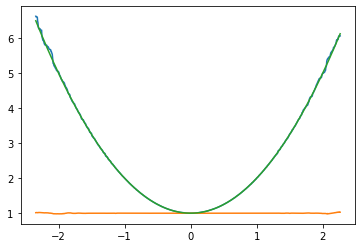

In [85]:
import matplotlib.pyplot as plt
pred_test_point = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                                                                              for tree, _ in forest), axis=0)
plt.plot(X_test[:, 0], pred_test_point)
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


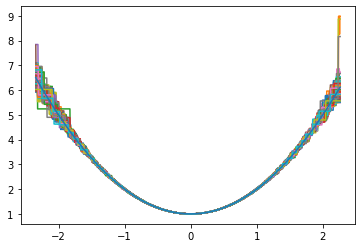

In [86]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest))[:, :, 0].T)
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()

In [76]:
alpha_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_precond)(X_test) for tree, _ in forest), axis=0)
J_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_jac)(X_test) for tree, _ in forest), axis=0)
pred_test_tree = np.einsum('ijk,ik->ij',
                           np.linalg.pinv(J_test_tree.reshape(-1, alpha_test_tree.shape[1], alpha_test_tree.shape[1])),
                           alpha_test_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


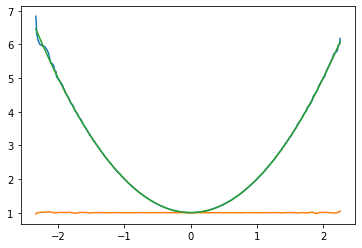

In [77]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test_tree)
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()

In [61]:
def predict(tree, X_test, X_train, alpha_train, pointJ_train, sample_weight_train):
    kernel = tree.apply(X_test).reshape(-1, 1) == tree.apply(X_train).reshape(1, -1)
    kernel = kernel * sample_weight_train.reshape(1, -1)
    kernel_norm = np.sum(kernel, axis=1, keepdims=True)
    alpha_test = kernel @ alpha_train / kernel_norm
    J_test = kernel @ pointJ / kernel_norm
    return np.hstack([alpha_test, J_test])

alphaJ_test = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(predict)(tree, X_test, X, alpha, pointJ, sample_weight)
                 for tree, sample_weight in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.6s finished


In [62]:
alpha_test, J_test = alphaJ_test[:, :alpha.shape[1]], alphaJ_test[:, alpha.shape[1]:]
pred_test = np.einsum('ijk,ik->ij', np.linalg.pinv(J_test.reshape(-1, alpha.shape[1], alpha.shape[1])), alpha_test)

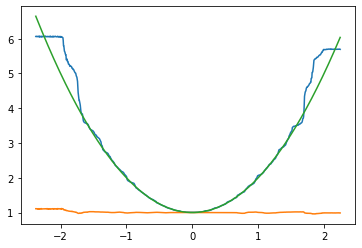

In [63]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test)
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()

In [64]:
np.testing.assert_almost_equal(alpha_test, alpha_test_tree)
np.testing.assert_almost_equal(J_test, J_test_tree)
np.testing.assert_almost_equal(pred_test, pred_test_tree)

In [65]:
from econml.causal_forest import CausalForest
from sklearn.linear_model import Lasso, MultiTaskLasso
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedMultiTaskLasso

est = CausalForest(n_trees=1000, subsample_ratio=.9, min_leaf_size=20,
                   max_depth=100, model_T=WeightedMultiTaskLasso(), model_Y=WeightedLasso()).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   37.3s finished


In [18]:
from econml.ortho_forest import DMLOrthoForest
from sklearn.linear_model import Lasso, MultiTaskLasso
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedMultiTaskLasso

est = DMLOrthoForest(n_trees=1000, subsample_ratio=.9, min_leaf_size=20,
                     max_depth=100, model_T=WeightedMultiTaskLasso(), model_Y=WeightedLasso()).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   43.7s finished


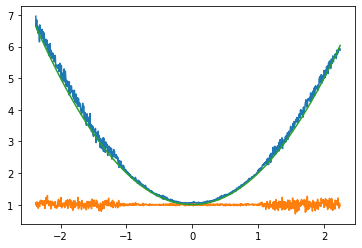

In [66]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0])
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()

In [2]:
from econml.ortho_forest import DMLOrthoForest
from sklearn.linear_model import Lasso, MultiTaskLasso
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedMultiTaskLasso

est = DMLOrthoForest(n_trees=1000, subsample_ratio=.9, min_leaf_size=20,
                     max_depth=100, model_T=WeightedMultiTaskLasso(), model_Y=WeightedLasso()).fit(y, T, X=X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.0s finished


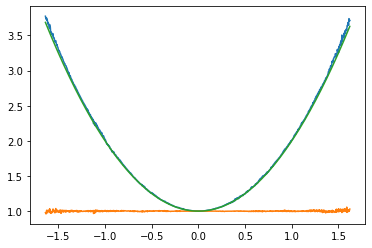

In [3]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0])
plt.plot(X_test[:, 0], X_test[:, 0]**2 + 1)
plt.show()